## Fraud Detection Project
Autor: Joshua kab

Fraud detection using Machine learning Algorightme.

This notebook I have indelve in this project to run an automated transaction processing to detects potentially fraudelant activity in the dataset.

###  Dataset info

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of the transactions and 99,8%   of the correct transaction.

The datasets contains only numerical input variables which are the result of a PCA transformation.

Due to confidentiality issues, there are not provided the original features and more background information about the data.

* Features V1, V2, ... V28 are the principal components obtained with PCA;
* The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
* Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

#### Loading python libraries

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#surprice warning output

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


### Read the dataset

In [3]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

Overview of the dataset, the first 5 rows

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset contains on numeric values

Data type informations 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The above result the dataset does not have a null values in all the features columns


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


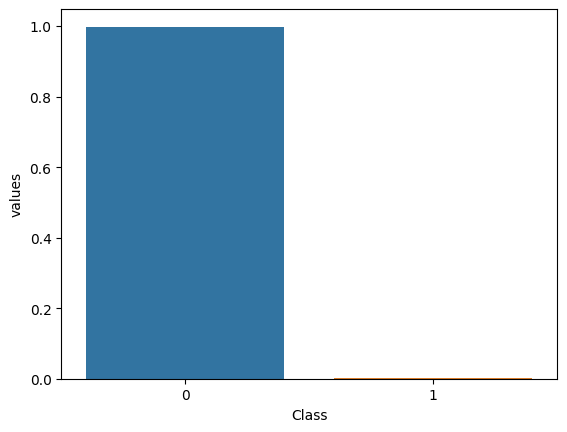

In [6]:
temp = df['Class'].value_counts(normalize=True)
temp_df = pd.DataFrame({'Class': temp.index,'values': temp.values})
#viz
sns.color_palette("flare", as_cmap=True)
sns.barplot(temp_df, x='Class', y='values')
print(temp)

Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced in respect with target variable Class.

#### Imbalanced dataset
An imbalanced dataset means the number of the majority class is much more than the minority class

In [7]:
feature_cols = df.columns[:-1]
df[['Time','Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


In the above result we can confirmed the numbers of transactions **284807** happend during 2 days or **172792** seconds

Let's dig deeper in the amount feature

In [8]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
data = pd.DataFrame(tmp)
data.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
data.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


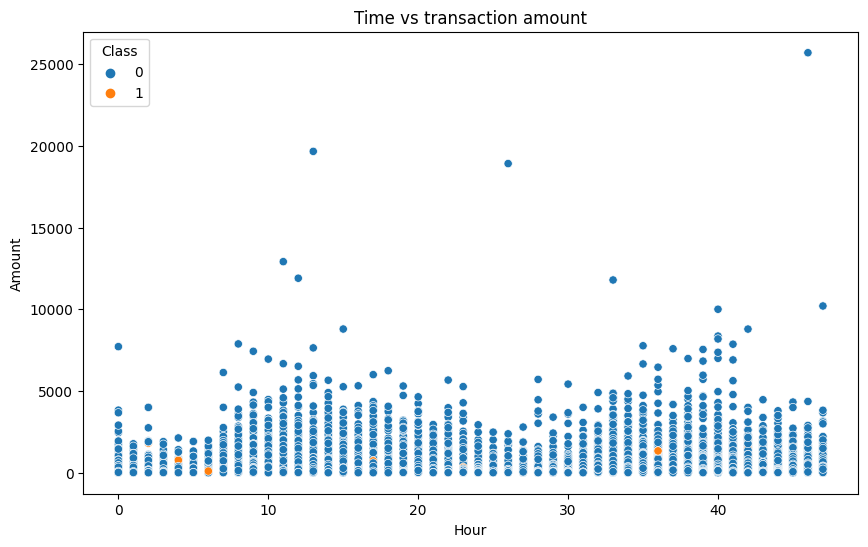

In [9]:
plt.figure(figsize=(10,6))
sns.color_palette("mako", as_cmap=True)
sns.scatterplot(data= df, x='Hour', y='Amount', hue='Class')
plt.title("Time vs transaction amount")
plt.show()

Since there is 0,17% of fraudelant transaction, it's a bit difficult to come to conclusion

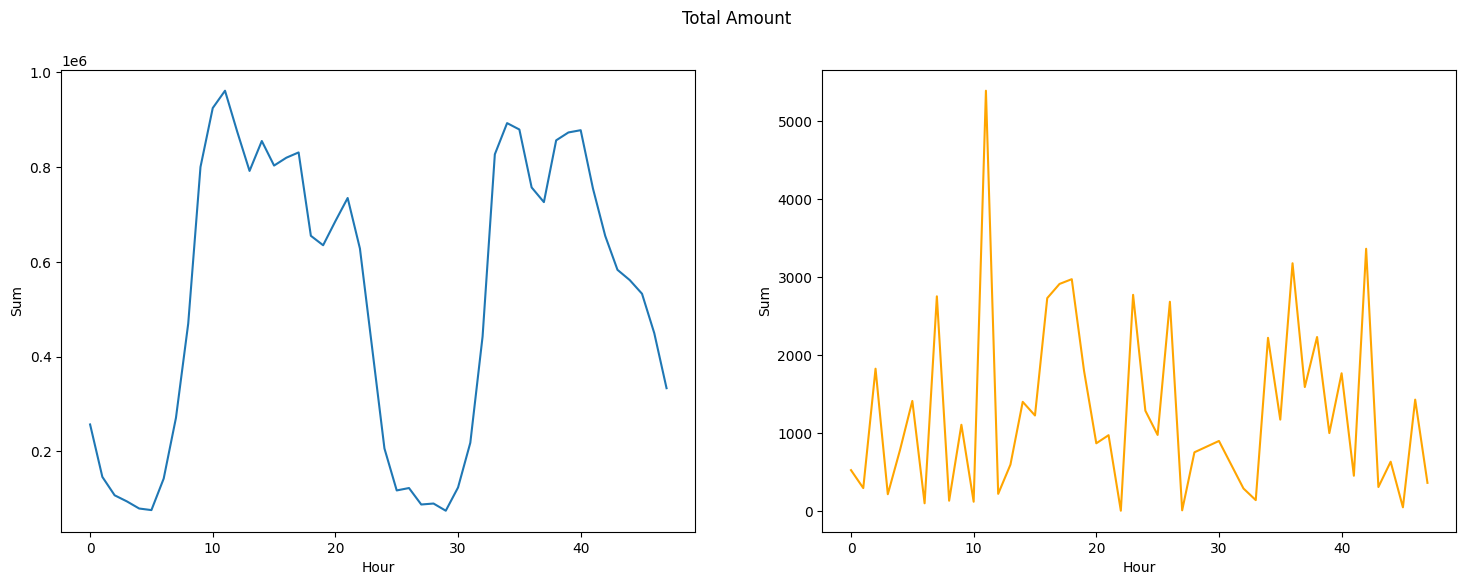

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=data.loc[data.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=data.loc[data.Class==1], color="orange")
plt.suptitle("Total Amount")
plt.show()

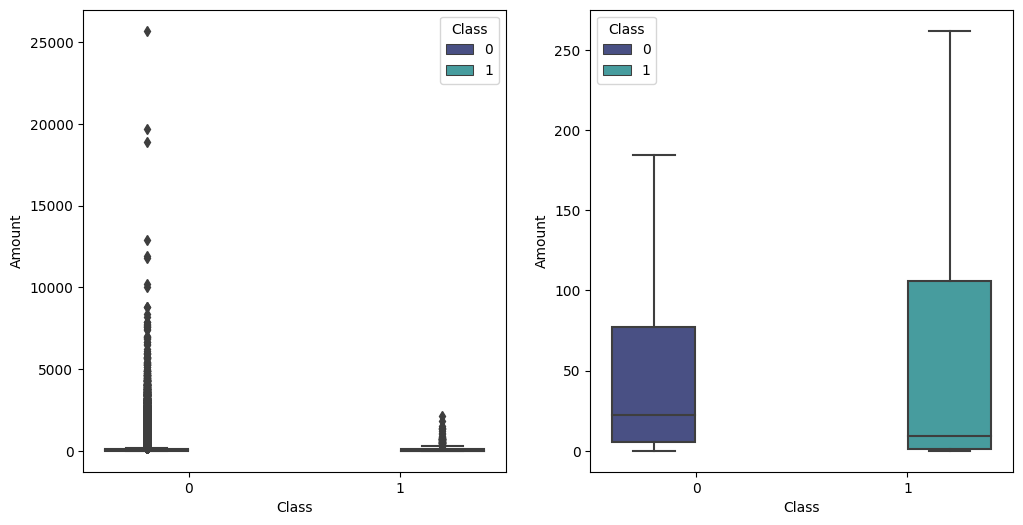

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="mako",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="mako",showfliers=False)
plt.show()

In [12]:
tmp = df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

The real transaction have a larger mean value, larger Q1, smaller Q3 and Q4 and larger outliers; fraudulent transactions have a smaller Q1 and mean, larger Q4 and smaller outliers

## Correlation check


In [14]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['Class']
top_features = df_num_corr[(df_num_corr) > 0.0].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} strongly correlated values with Class:\n{}".format(len(top_features), top_features))

There is 14 strongly correlated values with Class:
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
Name: Class, dtype: float64


### Machine Leaning Model

In [15]:

# Assuming your dataset is loaded into a DataFrame called 'df'
# df = pd.read_csv('your_dataset.csv')

# Feature selection and encoding
X = df.drop(['Class'], axis=1)
y = df['Class']


In [16]:
### StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df.Class))

# Create the dataframes
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'Class']

X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'Class']

let's check the shape of split data

In [17]:
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (199364, 30), y_train: (199364,)
Testing dataset shape, X_test: (85443, 30), y_test: (85443,)


## 1.Logistic RegressionCV

In [18]:
LR =  LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear')

LR = LR.fit(X_train, y_train)

In [19]:
y_pred = LR.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.61      0.71       148

    accuracy                           1.00     85443
   macro avg       0.93      0.80      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy score:  1.0
F1 Score:  0.71


## 2.LogisticRegresion l2

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85443
           1       0.00      0.00      0.00         0

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



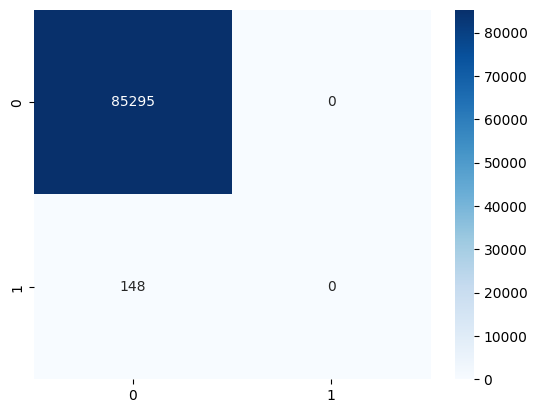

In [20]:
### logisticRegression l2
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))
#heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## 3. DecisionTreeClassifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=15,  min_samples_leaf=5, random_state=42)
dt = dt.fit(X_train, y_train)

In [22]:
dt.tree_.node_count, dt.tree_.max_depth

(137, 15)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

The decision tree predicts a little better on the training data than the test data, which is consistent with (mild)  overfitting. Also notice the perfect recall score for the training data. In many instances, this prediction difference is even greater than that seen here. 

In [24]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.999629,0.999228
precision,0.947020,0.805970
recall,0.831395,0.729730
f1,0.885449,0.765957


## KNN (K- Nearest Neighbors)Algorithm.


In [25]:
from sklearn.neighbors import KNeighborsClassifier
n = np.arange(1, 30)
knn = KNeighborsClassifier(n_neighbors = 10, metric='minkowski', n_jobs=1, leaf_size=5)
    
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy score:  1.0
F1 Score:  0.0


In [26]:
neighbors = np.arange(1, 7)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors = 100, metric='minkowski', n_jobs=5, leaf_size=5)
    
    #Fit the model
    knn = knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

    test_accuracy[i] = knn.score(X_test, y_test)

#print the accuracy result
accuracy = accuracy_score(y_test, y_test)
print("Accuracy:", train_accuracy[i])
print("test accuracy:", test_accuracy[i])
print("test accuracy:", test_accuracy[i])

Accuracy: 0.9982745129511847
test accuracy: 0.9982678510820079
test accuracy: 0.9982678510820079


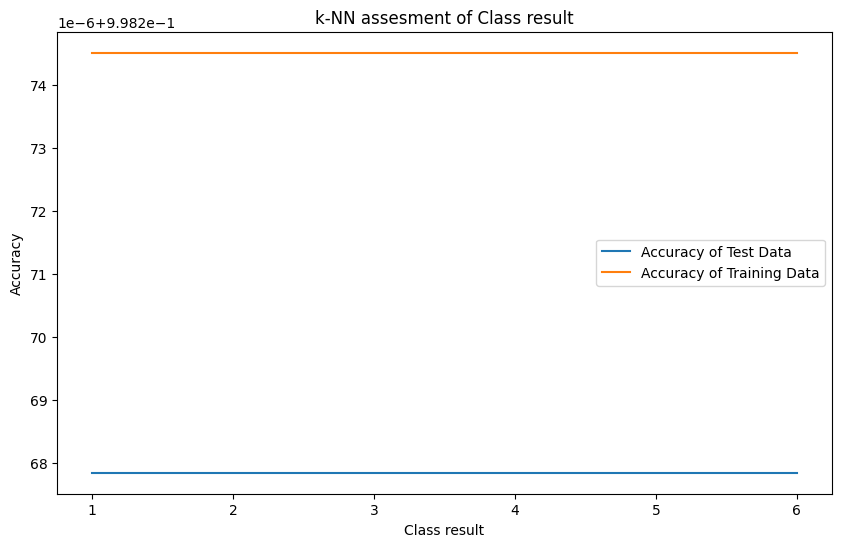

In [27]:
plt.figure(figsize=(10,6))
plt.title('k-NN assesment of Class result')
plt.plot(neighbors, test_accuracy, label='Accuracy of Test Data')
plt.plot(neighbors, train_accuracy, label='Accuracy of Training Data')
plt.legend()
plt.xlabel('Class result')
plt.ylabel('Accuracy')
plt.show()

## Using Cross Validation to Get the Best Value of k

Text(0, 0.5, 'Accuracy Score')

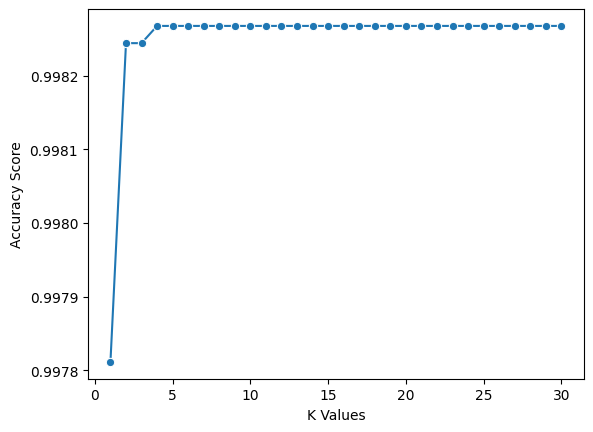

In [28]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    score = cross_val_score(knn,X_test, y_test, cv=5)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

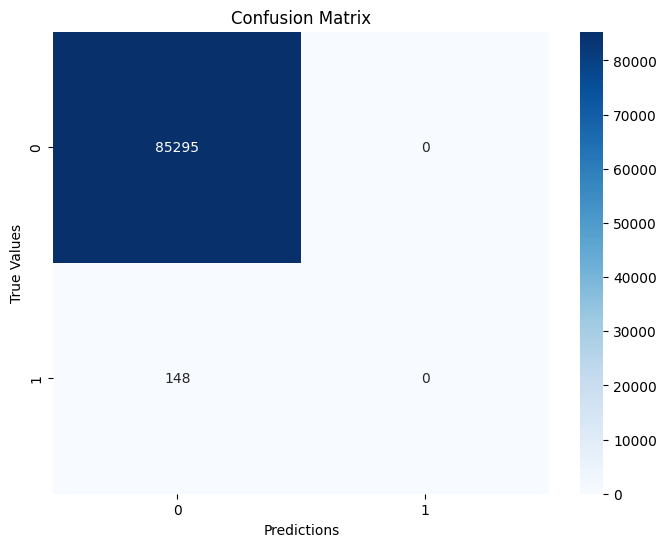

In [29]:
# Plot confusion matrix
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.show()

## 4. GridsearshCV

GridsearchCV

* Using grid search with cross validation, find a decision tree that performs well on the test data set. Use a different variable name for this decision tree model than in question 3 so that both can be used in question 6.
* Determine the number of nodes and the depth of this tree.
* Measure the errors on the training and test sets as before and compare them to those from the tree in question 3.

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

The number of nodes and the maximum depth of the tree.

In [31]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(123, 9)

These test errors are a little better than the previous ones. So it would seem the previous example overfit the data, but only slightly so.

In [32]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

In [33]:
train_test_gr_error

,train,test
accuracy,0.999774,0.999239
precision,1.000000,0.854701
recall,0.869186,0.675676
f1,0.930016,0.754717


Classification raport

## 5. Adabosster


In [34]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [35]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=100)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [36]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85349
           1       0.54      0.85      0.66        94

    accuracy                           1.00     85443
   macro avg       0.77      0.93      0.83     85443
weighted avg       1.00      1.00      1.00     85443



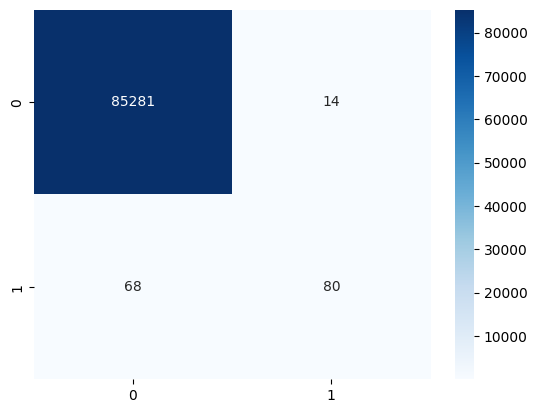

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## 6. XBOOST

In [38]:
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, objective='binary:logistic')
#Fit the model
XGB.fit(X_train, y_train)
pred_xgb = XGB.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred_xgb)
F1_score = f1_score(y_test, pred_xgb)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {F1_score}')
print(classification_report(y_test, pred_xgb))

Accuracy: 0.9994967405170698
F1_score: 0.8365019011406843
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.74      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



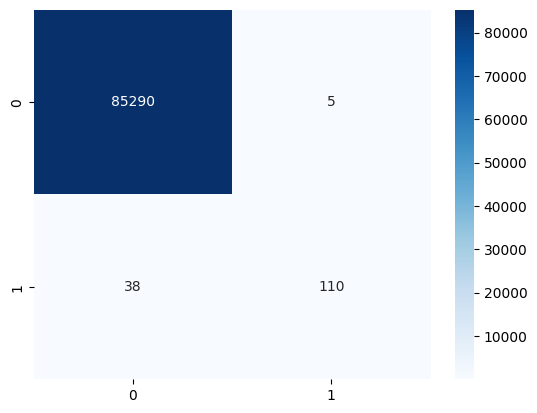

In [39]:
cm = confusion_matrix(y_test, pred_xgb)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()


## 7.Stacking model - Voting Classifier

In [40]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR', LR), ('LR_L2', LR_L2), ('GR', GR), ('dt', dt), ('GV_ABC', GV_ABC), ('Knn', knn), ('XGB', XGB)]

# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Performance for the voting classifier should improve relative to either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder to try the simplest model first. In some cases, its performance will be good enough.


In [41]:
VC.estimators_

[LogisticRegressionCV(cv=4, penalty='l1', solver='liblinear'),
 LogisticRegression(max_iter=500, solver='saga'),
 GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
              param_grid={'max_depth': range(1, 16, 2),
                          'max_features': range(1, 31)},
              scoring='accuracy'),
 DecisionTreeClassifier(max_depth=15, min_samples_leaf=5, random_state=42),
 GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1)),
              n_jobs=-1,
              param_grid={'learning_rate': [0.01, 0.001],
                          'n_estimators': [100, 150, 200]},
              scoring='accuracy'),
 KNeighborsClassifier(n_neighbors=30),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=Non

Predict

In [42]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))
#EVALUATION SCORE
accuracy = accuracy_score(y_test, y_pred)
F1_score = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1_score: {F1_score}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.99      0.62      0.76       148

    accuracy                           1.00     85443
   macro avg       0.99      0.81      0.88     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy: 0.9993328885923949
F1_score: 0.7634854771784233


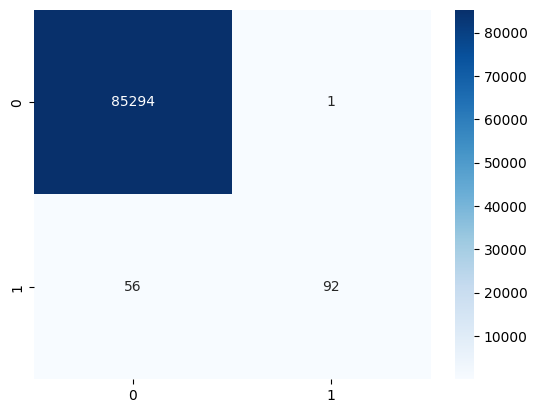

In [43]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()
#sns.set_context('talk')
#cm = confusion_matrix(y_test, y_pred)
#ax = sns.heatmap(cm, annot=True, fmt='d')


Plot Roc curve

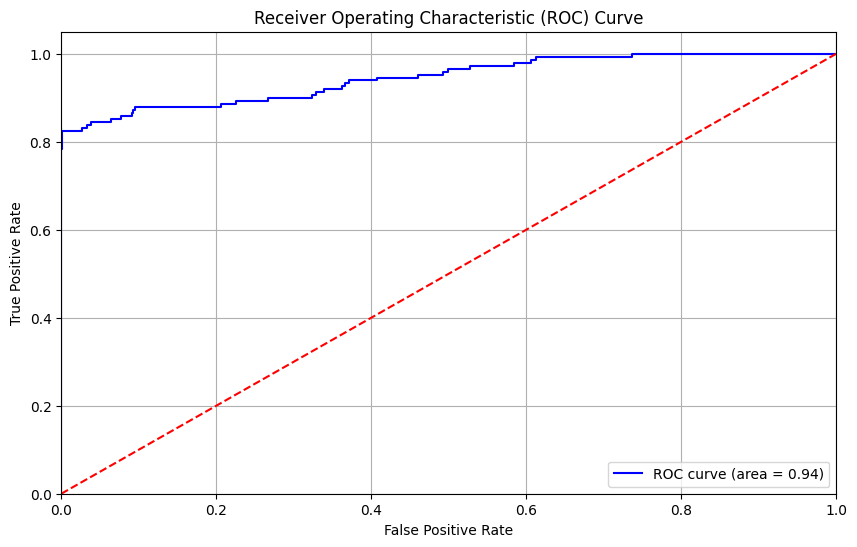

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_scores = VC.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_scores)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Model evaluation

In [45]:
# Define parameter grid for GridSearchCV
param_grid = {
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 5, 10]
}

# Define estimators for VotingClassifier
estimators = [
    ('logistic', LogisticRegression()),
    ('knn', KNeighborsClassifier()),
    ('xgboost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
]

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "GridSearchCV": GridSearchCV(DecisionTreeClassifier(random_state=42),
                                  param_grid=param_grid,
                                  scoring='accuracy',
                                  n_jobs=-1),
    "Logistic Regression CV": LogisticRegressionCV(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Voting Classifier": VotingClassifier(estimators, voting='soft'),
    "AdaBoost": AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
}

# Train models and evaluate performance
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')  # Use 'weighted' for multi-class
    results[model_name] = {'accuracy': acc, 'f1_score': f1}

# Create a DataFrame for results
results_df = pd.DataFrame(results).T
print(results_df)

                        accuracy  f1_score
Logistic Regression     0.999064  0.998986
XGBoost                 0.999485  0.999456
GridSearchCV            0.999181  0.999166
Logistic Regression CV  0.999029  0.998923
KNN                     0.998303  0.997489
Voting Classifier       0.999415  0.999355
AdaBoost                0.999181  0.999163


### Please UPVOTE if you like this notebook